Expected OEE = 0.8263111969273678


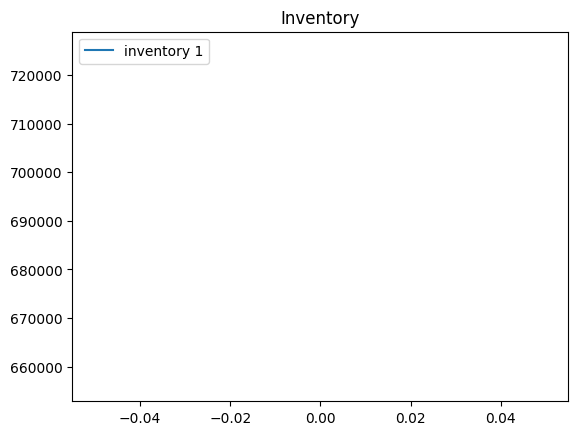

product 1
Actual avg inventory 1 level = 690895
Actual avg inventory 1 level = 7.7 weeks
number of demand events = 0
number of production jobs = 0
number of inbound storage events = 0
number of outbound storage events = 0


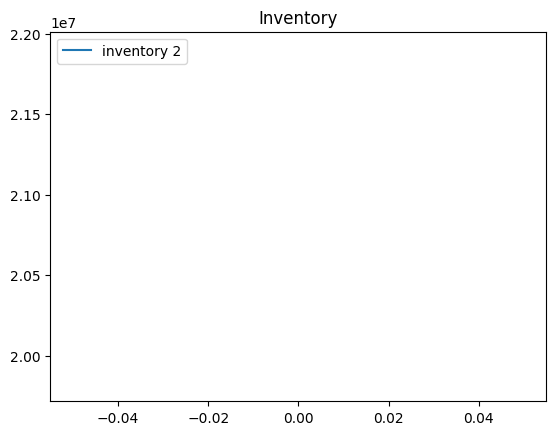

product 2
Actual avg inventory 2 level = 20863911
Actual avg inventory 2 level = 4.8 weeks
number of demand events = 0
number of production jobs = 1
number of inbound storage events = 0
number of outbound storage events = 0


ZeroDivisionError: ignored

In [ ]:
# -*- coding: utf-8 -*-
"""
Simulates a plant with one machine and two products
Implements:
    - demand and forecast generation
    - demand fulfillment from stock
    - stock reorder point observation and control
    - dynamic economic order quantity calculaion
    - sequence scheduling

Limitations:
- The time unit is 1 for one day. First day is 0.
- Rough and ready, some of the patterns have not been tested yet
- Currently limited to 1 order per product per day, bucket is also 1 day
- no machine breakdowns implemented yet

@author: ruekgauer

Changelog:
    V 1.0 17.4.23 Initial external version
          24.4.23 minor adjustment: OEE is w/o setup time
    V 1.1  2.5.23 Inventory init uses the very regime later required for sim
                  at startup, an expected OEE is calculated
    V 2.0 16.5.23 Demand determination changed to compounded Poisson
                  process which better reflects reality. This requires major
                  adjustments, therefore major revision change
                  added demand and fulfillment tracking
    V 2.1 19.6.23 added validated real demand data (former data error eliminated)
          22.6.23 corrected forecast calculation offset error by introducing carryover
                  minor fixes here and there
                  corrected service level calc, skip d=0 incidences
                  minor pythonizations all over the place
                  dynamized main, added comments
    V 2.2 26.6.23 adjusted demand data according to new information from client
           6.7.23 Added some statistics: inv.n_put/n_get, dmnd.n_jobs
    V 2.3  7.7.23 Fixed round and trunc errors in demand and forecast generation
                  introduced functions for both for easier debugging
                  OEE looks much better now, also number of prod jobs
"""

"""
Time and date definitions and conventions used herein
"""
DAYS_PER_WEEK = 7
WEEKS_PER_YEAR = 52
DAYS_PER_YEAR = WEEKS_PER_YEAR * DAYS_PER_WEEK
HOURS_PER_DAY = 24
SEC_PER_HOUR = 60 * 60
SEC_PER_DAY = SEC_PER_HOUR * HOURS_PER_DAY
# this is the central scaling factor for the simulation:
ONE_DAY = 1.0
FIFTEEN_MINUTES = ONE_DAY / HOURS_PER_DAY / 60 * 15

"""
Definition of start and end of simulation
"""
SIM_CYCLES = 1
SIM_START = 0.0
SIM_END = SIM_CYCLES * ONE_DAY

"""
Process specific definitions
"""
# distribution form for all stochastic data, see options below:
DISTRI_FORM = 'Lognorm'
# can or cannot provide partial shipments:
ALLOW_PART_SHIPMENTS = True
# rounding base for demands and forecasts:
RBASE = 1000
# size of the forecast for all products:
DAYS_FC = 180
# span in periods used in case of fixed order period quantity determination:
FOP_PERIODS = 30
# var coef for machine execution per propdution step:
MACHINE_VARCOEF = 0.1
# scheduling regime used herein, see defitions below:
SCHEDULING_REGIME = 'SPT'

"""
We are dealing with 2 products herein, their corresponding economic framework
defined as follows

The demand is double stochastic: a Poisson time distance, and a (not quite) Lognorm amount variation

1. Niche product, low demand, high volatility
2. Volume product: high demand, low volatility

The real machine OEE is anywhere between 69% and 82%
"""
QUANT_MU = 24400 # product 1 is low amount, high volatility, high uncertainty
DIST_DAYS = 1.9
p1 = { \
    'd_mu'         : QUANT_MU, # number of pieces per day produced \
    'd_varcoef'    : 0.75, # var coef for demand determination \
    'd_t_mu'       : DIST_DAYS, # number of days on avg between 2 orders \
    'd_fc_noise'   : 1.0, # var coef of forecast noise 0...1 as percentage of on top of it \
    'safety_stock' : 1.0 * QUANT_MU / DIST_DAYS * DAYS_PER_WEEK, # safety stock: 1 week \
    'E_p'          : 0.03,  # cost per piece for economic order quantity calc \
    'B_k'          : 200,  # setup cost per batch for eoq calc \
    'irate'        : 0.1,  # inventory interest for eoq calc \
    't_e'          : 0.22 / SEC_PER_DAY,  # production time per piece in fractions of a day \
    't_r'          : 2.0 / HOURS_PER_DAY,  # setup time per batch in fractions of a day \
    'eoq_mode'     : 'FOP' # which eoq model to use, definitions see below \
}

QUANT_MU = 978000 # product 2 is high amount, low volatility, medium uncertainty
DIST_DAYS = 1.58
p2 = { \
    'd_mu'         : QUANT_MU, \
    'd_varcoef'    : 0.75,  \
    'd_t_mu'       : DIST_DAYS, \
    'd_fc_noise'   : 0.5, \
    'safety_stock' : 1.0 * QUANT_MU / DIST_DAYS * DAYS_PER_WEEK, \
    'E_p'          : 0.04, \
    'B_k'          : 300,  \
    'irate'        : 0.1,  \
    't_e'          : 0.11 / SEC_PER_DAY, \
    't_r'          : 2.0 / HOURS_PER_DAY, \
    'eoq_mode'     : 'FOP' \
}

master_product_data = [p1, p2]


"""
Stochastic support functions
"""

def round_to(val, rbase) -> float:
    """
    self explanatory, rounts val to rbase, result can be float
    """
    assert rbase != 0.0, 'rbase must not be 0'
    return round(val / rbase) * rbase

import random
import numpy

def lognorm(mu, varcoef) -> float:
    """
    scales the target expected value mu and varcoef = sigma/mu to the
    embedded normal distribution with mu0 and sigma0 and returns
    the corresponding output
    beauty of lognorm: is always > 0
    """
    mu0 = numpy.log(mu / numpy.sqrt(numpy.power(varcoef, 2) + 1.0))
    sigma0 = numpy.sqrt(numpy.log(numpy.power(varcoef, 2) + 1.0))
    return random.lognormvariate(mu0, sigma0)

def lognorm_int(mu, varcoef, rbase) -> int:
    """
    integer variant of lognorm to base rbase
    """
    return round(round_to(lognorm(mu, varcoef), rbase))

"""
Validation:
mu = 10000.0
vc = 1.0
res = [lognorm_int(mu, vc, 100.0) for _ in range(10000)]
print(f'avg = {sum(res)/len(res)}')
"""

def uniform(mu, varcoef) -> float:
    """
    scales the target expected value mu and varcoef = sigma/mu to the
    uniform distribution parameters [a, b] and returns
    the corresponding output
    """
    a = (1.0 - numpy.sqrt(3.0) * varcoef) * mu
    b = (1.0 + numpy.sqrt(3.0) * varcoef) * mu
    assert a > 0, 'sqrt(3) * varcoeff must be < 1'
    return numpy.random.uniform(a, b)

def uniform_int(mu, varcoef, rbase) -> int:
    """
    integer variant of uniform to base rbase
    """
    return round(round_to(uniform(mu, varcoef), rbase))

def poisson(mu) -> float:
    """
    returns the poisson value for mu
    """
    return numpy.random.poisson(mu)

def poisson_int(mu, rbase) -> int:
    """
    integer variant of poisson to base rbase
    """
    return round(round_to(poisson(mu), rbase))

"""
Validation:
mu = 2.0
res = [poisson_int(mu, 1.0) for _ in range(10000)]
print(f'avg = {sum(res)/len(res)}')
"""

def distri_int(mu, varcoef, rbase) -> int:
    """
    wrapper for distribution forms
    supports lognormand uniform distribution
    """
    if DISTRI_FORM == 'Lognorm':
        return lognorm_int(mu, varcoef, rbase)
    elif DISTRI_FORM == 'Uniform':
        return uniform_int(mu, varcoef, rbase)
    else:
        raise ValueError('{DISTRI_FORM} not defined')

"""
Validation:
mu = 2000000.0
vc = 1.0
res = [distri_int(mu, vc, 1.0) for _ in range(10000)]
print(f'avg = {sum(res)/len(res)}')
"""

def distri(mu, varcoef) -> float:
    """
    wrapper for distribution forms
    comments see aove
    """
    if DISTRI_FORM == 'Lognorm':
        return lognorm(mu, varcoef)
    elif DISTRI_FORM == 'Uniform':
        return uniform(mu, varcoef)
    else:
        raise ValueError('{DISTRI_FORM} not defined')


def gen_demands(d_mu, d_varcoef, d_t_mu, rbase, nextd, curtd, amount):
    """
    generates a demand stream of length amount

    returns nextd, curtd, demands

    d_mu, d_varcoef: demand distri params for amplitude
    d_t_mu: demand distri param for time
    rbase: rounding base
    nextd: next time step for demand from here, is input and output
    curtd: current time step from last demand, is input and output
    amount: number of days, one element per day

    6-7-23: created this function, fixed curtd counter to start at 1 insread of 0
    """
    new_demands = []
    for _ in range(amount):
        if curtd >= nextd:
            new_demands.append(distri_int(d_mu, d_varcoef, rbase))
            curtd = 1
            nextd = poisson_int(d_t_mu, 1.0)
        else:
            new_demands.append(0)
            curtd += 1
    return curtd, nextd, new_demands



def gen_fc(d, d_fc_noise, d_mu, d_varcoef, rbase):
    """
    generates a forecast for the demand vector d
    returns the forecast vector which is of same length as the demand vector

    d_fc_noise: noise level in ratio
    d_mu: mu of demand distribution
    d_varcoef: var coef of demand distribution
    rbase: rounding base

    6-7-23: created this function, rewrote the code, not it miraculously works somehow!
    """
    forecasts = []
    # the problem is truncation to positive forecast numbers. to do so and preserve the
    # stochastic qualities, noise_carryover stores the trunc'd values and adds them later on
    trunc_carryover = 0
    for di in d:
        noise = round_to(d_fc_noise * (distri_int(d_mu, d_varcoef, 1.0) - d_mu), rbase)
        fci = max(0, di + noise + trunc_carryover)
        noise_carryover = min(0, di + noise + trunc_carryover)
        forecasts.append(fci)
    return forecasts

"""
Validation:
p = p2
dmu = p['d_mu']
vc = p['d_varcoef']
dt = p['d_t_mu']
rb = RBASE
noise = 1.0
a, b, d = gen_demands(dmu, vc, dt, rb, 0, 0, 50000)
print(f'avg d = {sum(d)/len(d)}, should be {dmu/dt}')
f = gen_fc(d, noise, dmu, vc, rb)
print(f'avg f = {sum(f)/len(f)}')
"""

class Demand():
    """
    demand class, implements
    - demand generation
    - forecast generation
    - fulfillment and backlog handling
    - statical fulfillment analysis
    by definition, one demand per day is assumed. Whenever demand is requested,
    it will be processed and new demand for the next day is generated, as well
    as forecast is updated

    actual future demand stream is stored internally for consistent generation of forecasts
    definition:
    - demands[0] is current. new demand is added at the end. demand[0] is
      removed from the front after fulfillment attempt),
    - demands[1:d_fc] are future demands used for forecasting

    Demand is always for 1 product

    from V1.1 it is essential for Demand.init to setup a full demand stream as
    it used for Inventory.init

    7-6-23: added n_jobs and related functionality
    """
    def __init__(self, p, rbase, d_fc, env):
        """
        inits everything and generates an initial demand pattern stream
        p: product
        rbase: rounding base
        d_fc: days forecast
        """
        self.p = p            # remembers product
        self.rbase = rbase    # rounding base
        self.n_good = 0       # counts the successful demand fulfillments
        self.n_bad = 0        # counts the unsuccessful ones (not on time or amount)
        self.backlog = 0      # stores the unfulfilled demands for later
        self.demands = []     # holds the actual demands[d_fc], subject, is a ring buffer with one entry for every day
        self.forecasts = []   # holds the noised up forcasts [d_fc, first entry is tomorrow] with one entry for every day
        self.nextd = 0        # next event in days where demand is generated
        self.curtd = 0        # pointer to current time relative to nextd
        self.t = []           # time stamp for fulfillment, just for analysis
        self.ff = []          # fulfilled amount
        self.d = []           # past actual demanded recorded for debugging und display purposes only
        self.delta_bl = []    # delta backlog
        self.env = env        # dto, just for analysis puposes
        self.n_jobs = 0       # number of production jobs scheduled over time

        # initially build demand stream, 1st is current demand
        self.nextd = poisson_int(p['d_t_mu'], 1)
        self.gen_demand_and_fc(d_fc + 1)

    def gen_demand_and_fc(self, amount):
        """
        generates new demand, simply a cast
        important: appends at the end (fulfill will purge at the front)
        and updates fc for demands other than current (1st in list)
        6-22-23: forecast corrected, was artifically high due to left = 0 trunc,
                 introduced carryover
        7-6-23: added function wrappers due to bug fix, made debugging easier
        """


        self.curtd, self.nextd, new_demands = gen_demands(self.p['d_mu'], self.p['d_varcoef'], \
                                                          self.p['d_t_mu'], self.rbase, \
                                                          self.nextd, self.curtd, amount)

        self.demands = self.demands + new_demands

        self.forecasts = gen_fc(self.demands[1:], self.p['d_fc_noise'], \
                                self.p['d_mu'], self.p['d_varcoef'], self.rbase)


    def fulfill(self, mat, allow_part_shipments) -> int:
        """
        mat : mateial amount handed down to manage demand stream
        allow_part_shipments : bool, allow for partial shipments or no
        return: material consumed for this step <= mat
        will remove demand (partially) fulfilled from front of demands list
        definition:
        - if demand cannot be fulfilled due to material constraints,
          backlog is built up
        - backlog is processed first, the current demand
        22.6.23: fixec step 2: only if demand > 0,otherwise the n_good counter is not correct
        """
        mat_used = 0
        bl0 = self.backlog

        # 1. first handle backlog as much as possible
        if mat >= self.backlog:
            mat_used += self.backlog
            mat -= self.backlog
            self.backlog = 0
        else:
            mat_used += mat
            self.backlog -= mat
            mat = 0
        # 2. then handle current demand step if necessary as much as possible and update statistics
        if self.demands[0] > 0:
            if mat >= self.demands[0]:
                self.n_good += 1
                mat_used += self.demands[0]
            else:
                self.n_bad += 1
                if allow_part_shipments:
                    self.backlog += (self.demands[0] - mat)
                    mat_used += mat
                    mat = 0
                else:
                    self.backlog += self.demands[0]
        # 3. purge current demand from ringbuffer and save statistics
        self.t.append(self.env.now)
        self.d.append(self.demands[0])
        self.ff.append(mat_used)
        self.delta_bl.append(bl0 - self.backlog)
        del self.demands[0]
        return mat_used

    def service_level(self):
        """
        calculates the service level at any time defined as
        # good shipments (proper amount and time) / # total number of demands
        """
        return self.n_good / (self.n_good + self.n_bad)

    def avg_daily_machine_time(self):
        """
        returns the expected daily machine time consumed by the product
        new definition from V2.0 on:
            daily demand = mu_d / d_t_mu
        """
        p = self.p
        daily_demand = p['d_mu'] / p['d_t_mu']
        daily_prod_time = daily_demand * p['t_e']
        eoq = eoq_dynamic(self.demands, p['E_p'], p['B_k'], p['irate'], p['eoq_mode'])
        daily_setup_time = p['d_mu'] / p['d_t_mu'] / eoq * p['t_r']
        return daily_prod_time + daily_setup_time


def eoq_static(J, E_p, B_k, Z) -> int:
    """
    implements the Andler formula
    note the various imitations, in particular, constant demand pattern which
    is most often violated herein
    J: annual demand
    E_p: unit cost
    B_k: setup cost per batch
    Z: interest per year for storage, capital, ...
    """
    return round(numpy.sqrt(2.0 * J * B_k / E_p / Z))

def eoq_dynamic(d, E_p, B_k, Z, mode) -> int:
    """
    calculcates the economic quanity, various models can be implemented
    d: demand list
    mode: see below
    rest like eoq_static
    6-20-23: fix for FOP: from d[0:x-1] to d[0:x]
    """
    if mode == 'Andler':
        # Andler, note this is not correct as the equation assumes constant demand
        sum_d = sum(d)
        len_d = len(d)
        J = round(sum_d / len_d * DAYS_PER_YEAR)
        return eoq_static(J, E_p, B_k, Z)
    elif mode == 'FOP':
        # fixed order period
        return sum(d[0:min(FOP_PERIODS, len(d))])
    else:
        raise ValueError('{mode} not defined')

class Inventory():
    """
    - passive device just holding inventory level and reorder point info
      initial amount = safety + static eoq
    - reorder point also static for replenishemnt cycle based on eoq * t_e + t_r
    - also stores all past levels for later analysis both in time and amounts
    - this class also holds the information for replenishment handling: at the
      beginning of a replen cycle, replen_due and replen_open are set to the least
      amount = rop - level, then this routine counts down replen_due and the
      fulfillment routine counts down replen_open

    Invenory is always for one product

    from V1.1 it uses the same quantity regime as planning uses

    7-6-23: added n_put and n_get and related functionality
    """
    def __init__(self, d, env):
        """
        d: demand instance
        env: simpy environment, only needed for env.now (statisical purposes)
        """
        p = d.p
        self.env = env
        self.t = [self.env.now]
        eoq = eoq_dynamic([d.demands[0]] + d.forecasts, \
                          p['E_p'], p['B_k'], p['irate'], p['eoq_mode'])
        self.levels = [p['safety_stock'] + eoq]
        self.reorder_point = round(p['safety_stock'] + p['d_mu'] * (eoq * p['t_e'] + p['t_r']))
        self.replen_due = 0
        self.replen_open = 0
        self.n_put = 0
        self.n_get = 0

    def avg_level(self):
        """
        provides the average inventory level at any time
        """
        return sum(self.levels[i] for i in range(len(self.levels))) / len(self.levels)

    def level(self):
        """
        provides the average inventory level (the last one in the list)
        at any time
        """
        return self.levels[len(self.levels) - 1]

    def put(self, amount):
        """
        adds given amount to inventor
        """
        assert amount >= 0, 'Inventory put amount must be >= 0'
        self.t.append(self.env.now)
        self.levels.append(self.level() + amount)
        self.n_put += 1

    def get(self, amount):
        """
        substracts given amount from inventor
        """
        assert self.level() >= amount, 'Inventory get amount must be lower than current level'
        assert amount >= 0, 'Inventory get amount must be >= 0'
        if amount == 0:
            return
        self.t.append(self.env.now)
        self.levels.append(self.level() - amount)
        self.n_get += 1

class ProdPlan():
    """
    class for production plan and execution for any one machine
    ProdPlan links one machine with a queue of product demands and inventories
    so the architecture is as follows:
        machine --> list of {demands, inventories always going together}
    implements
    - planing step including reorder point, economic equantity and order scheduling
    - actual scheduling
    - production step
    """
    def __init__(self, scheduling_regime, varcoef, di_queue):
        """
        scheduling regime: see below
        varcoef: sigma/mu for any one production stepsize
        di_queue: pipeline of demands and inventories
        internal: job list holding the production pipeline
        """
        self.joblist = []
        self.scheduling_regime = scheduling_regime
        self.last_prod = None # remember past product produced to add setup time
        self.varcoef = varcoef # variance coef for both setup and execution
        self.di_queue = di_queue
        self.prod_time = 0 # stores the pure execution time
        self.setup_time = 0 # stores the pure setup time

    def plan(self, now):
        """
        this routine adds prod jobs, the produce routine eliminates them again
        starts with adding new orders (generating new demand)
        then takes demand/inventory pipeline, fills job pipeline
        """
        # for all demand and inventory tuples
        for di in self.di_queue:
            d = di['d']
            inv = di['inv']
            p = d.p
            # 1. get new demand and forecast
            d.gen_demand_and_fc(1)
            # 2. check reorder point
            # . check and start new cycle if needed
            if inv.level() <= inv.reorder_point and inv.replen_due <= 0:
                inv.replen_due = inv.reorder_point - inv.level()
                inv.replen_open = inv.replen_due
            # . keep adding jobs if not yet enough issued
            if inv.replen_open > 0:
                # 3. economic quantity
                eoq = eoq_dynamic([d.demands[0]] + d.forecasts, \
                                  p['E_p'], p['B_k'], p['irate'], p['eoq_mode'])
                # yes, it is possbile that we are below rop and yet eoq = 0!
                if eoq > 0:
                    # add to job list
                    self.joblist.append({'amount': eoq, 'date': now, 'inv': inv, 'p': p})
                    inv.replen_open -= eoq
                    d.n_jobs += 1
        # 4. sequence scheduling
        self.schedule()

    def schedule(self):
        """
        several classic job sequence scheduling algorithms are provided
        so far, only SPT has been used and tested!
        a sorter column is added, used and removed again
        22.6.23: pythonized new version
        """
        # generate sorter column depending on scheduling regime
        if self.scheduling_regime == 'Value':
            ascend = False
            self.joblist = [jb | {'sorter': jb['amount'] * jb['p']['E_p']} for jb in self.joblist ]
        elif self.scheduling_regime == 'SPT':
            ascend = True
            self.joblist = [jb | {'sorter': jb['amount'] * jb['p']['t_e']} for jb in self.joblist ]
        elif self.scheduling_regime == 'LPT':
            ascend = False
            self.joblist = [jb | {'sorter': jb['amount'] * jb['p']['t_e']} for jb in self.joblist ]
        elif self.scheduling_regime == 'Slip':
            ascend = True
            self.joblist = [jb | {'sorter': jb['date'] - jb['amount'] * jb['p']['t_e']} for jb in self.joblist ]
        else:
            raise ValueError('{scheduling_regime} not defined')
        # sort by sorter
        self.joblist = sorted(self.joblist, key = lambda k: k['sorter'], reverse = ascend)
        # eliminate sorter
        self.joblist = list(filter(lambda x: x.pop('sorter', None) or True, self.joblist))


    def produce(self):
        """
        execute first job in the list and eliminte entry
        deliverables are:
        - duration of production job,
        - amount of parts produced,
        - inventory to store the parts into
        storage is handled outside, because we have to wait for the production to be finished
        first. this is handled outside to separate functions
        """
        if len(self.joblist) == 0:
            return 0, 0, 0
        job = self.joblist[0]
        amount = job['amount']
        inv = job['inv']
        p = job['p']
        assert amount > 0, 'production amount must be > 0'
        # add production time to duration
        # note varcoef applies to every prod step, so due to addition of variances we must divide by sqrt(amount)
        dur = distri(amount * p['t_e'], self.varcoef / numpy.sqrt(amount))
        self.prod_time += dur
        # add setup time to duration, but only if product switch. remember current product produced
        st = distri(p['t_r'], self.varcoef) if self.last_prod != p else 0.0
        dur += st
        self.setup_time += st
        self.last_prod = p
        del self.joblist[0]
        return dur, amount, inv

"""
from here one the process wrappers
"""

def produce(env, pp):
    """
    simple process wrapper around production plan execution part and inventory update
    runs a production plan, so it runs one machine
    produce has no bucket, as it continuesly processes all jobs pending
    """
    while True:
        dur, amount, inv = pp.produce()
        if dur > 0:
            # wait duration - note if breakdowns are implmented, the waiting time can be longer
            yield env.timeout(dur)

            # store product after the production is finished, no earlier!
            inv.put(amount)
            inv.replen_due -= amount
        else:
            # wait a bit to prevent infinite loop
            yield env.timeout(FIFTEEN_MINUTES)

def fulfill(env, d, inv, allow_part_shipments, bucket):
    """
    demand fulfillment process for one set of demand and inventory, per bucket
    env : simpy environment
    d : demand instance
    inv : inventory process instance
    """
    while True:
        # provide all material to demand, deduct consumed amount from inventory
        max_mat = inv.level()
        mat_used = d.fulfill(max_mat, allow_part_shipments)
        inv.get(mat_used)
        yield env.timeout(bucket)


def plan(env, pp, bucket):
    """
    run one planning cycle per bucket
    so plan for 1 machine
    """
    while True:
        pp.plan(env.now)
        yield env.timeout(bucket)

"""
finally the actual program
"""

import simpy
import datetime

if __name__ == '__main__':

    """
    22.6.23: dynamic version with as many products on one machine as given
             my the master product data list
    """
    # init random engine
    random.seed(datetime.datetime.now().second)
    # init sim environment
    env = simpy.Environment(initial_time = SIM_START)

    # init demands, inventories per product, and production plan and execution per machine
    dl = []
    for p in master_product_data:
        dl.append(Demand(p, RBASE, DAYS_FC, env))

    avg_OEE = 0
    for d in dl:
        avg_OEE += d.avg_daily_machine_time() / ONE_DAY
    print(f'Expected OEE = {avg_OEE}')

    il = []
    for d in dl:
        il.append(Inventory(d, env))

    demand_and_inv_pipeline = [{'d': d, 'inv': i} for d, i in zip(dl, il)]
    pp = ProdPlan(SCHEDULING_REGIME, MACHINE_VARCOEF, demand_and_inv_pipeline)

    # launch fulfillments per product, and planning and production per machine
    for d, i in zip(dl, il):
        env.process(fulfill(env, d, i, ALLOW_PART_SHIPMENTS, ONE_DAY))
    env.process(plan(env, pp, ONE_DAY))
    env.process(produce(env, pp))

    # run sim
    env.run(until = SIM_END)

    # post production: data analysis if desired
    if True:

        import matplotlib.pyplot as plt

        for i, (inv, p, di) in enumerate(zip(il, master_product_data, dl)):

            # plot inventory levels over time
            plt.figure()
            plt.plot(inv.t, inv.levels, label='inventory ' + str(i+1))
            plt.legend(loc = 'upper left')
            plt.title('Inventory')
            plt.show()
            print(f'product {i+1}')
            # show actual avg inventory levels in pcs
            print(f'Actual avg inventory {i+1} level = {round(inv.avg_level())}')

            # show actual avg inventory levels in weeks
            avg_dmnd_per_week = p['d_mu'] * DAYS_PER_WEEK / p['d_t_mu']
            avg_inv_weeks = round(inv.avg_level() / avg_dmnd_per_week * 10.0) / 10.0
            print(f'Actual avg inventory {i+1} level = {avg_inv_weeks} weeks')

            print(f'number of demand events = {di.n_good + di.n_bad}')
            print(f'number of production jobs = {di.n_jobs}')
            print(f'number of inbound storage events = {inv.n_put}')
            print(f'number of outbound storage events = {inv.n_get}')

        for i, d in enumerate(dl):

            # show actual service level
            print(f'Actual service level demand {i+1} = {d.service_level()}')

            # plot demand, fulfillment, backlog
            plt.figure()
            plt.plot(d.t, d.d, label='demand')
            plt.plot(d.t, d.ff, label='fulfilled')
            plt.plot(d.t, d.delta_bl, label='delta backlog')
            plt.legend(loc = 'upper left')
            plt.title(f'Demand {i+1}')
            plt.show()

        # show actual OEE:
        OEE = pp.prod_time / (SIM_END - SIM_START)
        print(f'Actual OEE = {OEE}')


In [ ]:
import simpy
import matplotlib.pyplot as plt

class ProdEnv:
  def __init__(self, p1, p2):
    self.env = simpy.Environment(initial_time = SIM_START)
    self.p1 = p1
    self.p2 = p2
    # init demands, inventories per product, and production plan and execution per machine
    self.dl = (Demand(self.p1, RBASE, DAYS_FC, self.env), Demand(self.p2, RBASE, DAYS_FC, self.env))
    self.il = (Inventory(self.p1, self.env), Inventory(self.p2, self.env))
    self.avg_OEE = 0

    self.dm_and_in_pip = [{'d': d, 'inv': i} for d, i in zip(self.dl, self.il)]
    self.pp = ProdPlan(SCHEDULING_REGIME, MACHINE_VARCOEF, self.dm_and_in_pip)

    # initializing the processes in the environment
    for d, i in zip(self.dl, self.il):
      self.env.process(fulfill(self.env, d, i, ALLOW_PART_SHIPMENTS, ONE_DAY))
    self.env.process(plan(self.env, self.pp, ONE_DAY))
    self.env.process(produce(self.env, self.pp))

    # other variables
    self.ONE_DAY = 1 # change here / decide whether to keep it or not


  def calc_OEE(self, show = False):
    # calculate the expected OEE
    self.avg_OEE += self.dl[0].avg_daily_machine_time() / self.ONE_DAY + self.dl[1].avg_daily_machine_time() / self.ONE_DAY
    if show:
      print("Expected OEE:", self.avg_OEE)


  def step(self):
    self.env.run(until = ONE_DAY) ###check here again with ONE_DAY (w/o self)
    pass


  def _get_obs(self):
    pass


  def reset(self):
    """
    Here needs to be decided what reset means in this case. It does not make sense
    to reset the environment/class, as long as the simulation needs to run continuously.
    """
    pass

  def plot_and_print(self):
    for i, (inv, p, di) in enumerate(zip(self.il, (self.p1, self.p2), self.dl)):
      # plot inventory levels over time
      plt.figure()
      plt.plot(inv.t, inv.levels, label='inventory ' + str(i+1))
      plt.legend(loc = 'upper left')
      plt.title('Inventory')
      plt.show()
      print(f'product {i+1}')
      # show actual avg inventory levels in pcs
      print(f'Actual avg inventory {i+1} level = {round(inv.avg_level())}')

      # show actual avg inventory levels in weeks
      avg_dmnd_per_week = p['d_mu'] * DAYS_PER_WEEK / p['d_t_mu']
      avg_inv_weeks = round(inv.avg_level() / avg_dmnd_per_week * 10.0) / 10.0
      print(f'Actual avg inventory {i+1} level = {avg_inv_weeks} weeks')

      print(f'number of demand events = {di.n_good + di.n_bad}')
      print(f'number of production jobs = {di.n_jobs}')
      print(f'number of inbound storage events = {inv.n_put}')
      print(f'number of outbound storage events = {inv.n_get}')

    for i, d in enumerate(self.dl):
      # show actual service level
      print(f'Actual service level demand {i+1} = {d.service_level()}')
      # plot demand, fulfillment, backlog
      plt.figure()
      plt.plot(d.t, d.d, label='demand')
      plt.plot(d.t, d.ff, label='fulfilled')
      plt.plot(d.t, d.delta_bl, label='delta backlog')
      plt.legend(loc = 'upper left')
      plt.title(f'Demand {i+1}')
      plt.show()





ProdEnv

__main__.ProdEnv